In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fewshot_dataset = ['aricraft', 'caltech101', 'cars', 'cifar10', 'cifar100', 'dtd', 'flowers', 'food', 'pets', 'sun397']

def get_head(path):
    if 'freezetext' in path or 'freezehead' in path or 'dino-txt' in path:
        if 'wit400m' in path or 'dino-txt' in path:
            return 'Frozen CLIP'
        elif 'roberta' in path:
            return 'Frozen Roberta'
        else:
            raise NotImplementedError
    elif 'inittext' in path:
        if 'wit400m' in path:
            return 'CLIP init'
        elif 'roberta' in path:
            return 'Roberta init'
        else:
            raise NotImplementedError
    else:
        return 'Rand init'

def get_num(path, key='sample', type=int, return_str=False):
    if type==float:
        res = re.findall(r'{}\d+\.\d+'.format(key), path)
    else:
        res = re.findall(r'{}[0-9]+'.format(key), path)
    if len(res) > 0:
        val = res[0].replace(key, '')
    else:
        val = str(-1)
    if return_str:
        return val
    else:
        return type(val)

def get_metrics(paths, task='fewshot'):
    metrics = []
    for path in paths:
        path = os.path.join(path, '{}.csv'.format(task))
        if os.path.exists(path):
            df = pd.read_csv(path, sep='\t')
            df['model'] = 'CLIP' if 'open_clip' in path else 'DINO' if 'dino' in path else 'SL'
            df['pretrain'] = 'LAIONet' if 'laionet' in path else 'ImageNet'
            df['head'] = get_head(path)
            subsample = get_num(path, key='samplehead' if df.loc[0, 'model'] == 'SL' else 'sample', type=int)
            proto = get_num(path, key='proto', type=int)
            proto = 65536 if proto == -1 else proto
            df['vocab'] = 1000 if subsample == -1 and df.loc[0, 'model'] == 'SL' else proto if subsample == -1 and df.loc[0, 'model'] == 'DINO' else subsample
            df['sample method'] = 'All' if subsample == -1 else 'Uniform' if 'unfm' in path else 'Square Root' if 'sqrt' in path else 'Linear'
            if task == 'fewshot' and df[df['dataset'] == 'all'].size > 0:
                df['dataset'] = fewshot_dataset[:len(df[df['dataset'] == 'all'])]
            metrics.append(df)
    metrics = pd.concat(metrics)
    metrics = metrics.reset_index(drop=True)
    return metrics

/Users/xwen/miniconda3/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/xwen/miniconda3/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/xwen/miniconda3/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/xwen/miniconda3/lib/python3.10/site-pac

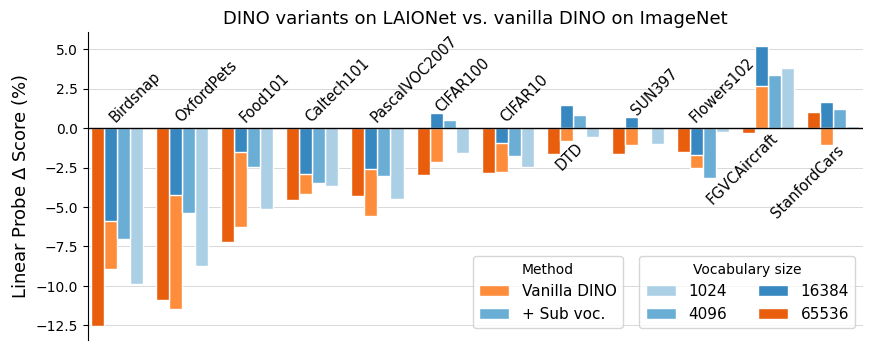

In [2]:
paths = [
    '../exps_dino/output/dino_imagenet_rn50_ep100_bs512/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024_sample1024/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024_sample4096/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024_sample16384/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024_proto16384/',
]

df = get_metrics(paths, task='linear')
baseline = df[df['pretrain'] == 'ImageNet']
df = df[df['pretrain'] != 'ImageNet'].copy()
plot_df = df[(df['temp'] == 0) & ((df['sample method'] != 'All') | (df['vocab'] == 65536))].copy()
delta_accs = [acc - baseline[baseline['dataset'] == ds]['test_acc'].item() for acc, ds in zip(plot_df['test_acc'].to_list(), plot_df['dataset'].to_list())]
plot_df.loc[:, 'delta_acc'] = delta_accs
plot_df = plot_df.sort_values(by=['dataset'])

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.yaxis.grid(color='gray', linestyle='-', linewidth=0.7, alpha=0.3, zorder=-1)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=4)

order = ['birdsnap', 'pets', 'food', 'caltech101', 'voc2007', 'cifar100', 'cifar10', 'dtd', 'sun397', 'flowers', 'aircraft', 'cars'][::-1]
datasets = ['Birdsnap', 'OxfordPets', 'Food101', 'Caltech101', 'PascalVOC2007', 'CIFAR100', 'CIFAR10', 'DTD', 'SUN397', 'Flowers102', 'FGVCAircraft', 'StanfordCars'][::-1]
positions = [.7] * 10 + [.68, .64]
positions[5] = .73
positions[7] = .65
positions[8] = .72
vas = ['bottom'] * 7 + ['top'] + ['bottom'] * 2 + ['top'] * 2
has = ['left'] * 7  + ['right'] + ['left'] * 2 + ['right'] * 2
shifts = [.15] * 7 + [-.2, .15, .25] + [-.2] * 2

positions = positions[::-1]
vas = vas[::-1]
has = has[::-1]
shifts = shifts[::-1]

blues = sns.color_palette('Blues', n_colors=5)[1:]
reds = sns.color_palette('Oranges', n_colors=5)
palette = blues[:-1] + [reds[3]]
sns.barplot(plot_df, x='dataset', y='delta_acc', hue='vocab', order=order, ax=ax, palette=palette, alpha=1, saturation=1, ec='w', linewidth=1, zorder=3)
legend1 = ax.legend(title='Vocabulary size', alignment='center', loc='lower right', ncol=2, bbox_to_anchor=(1, .015), fontsize=11)

delta_accs = [acc - baseline[baseline['dataset'] == ds]['test_acc'].item() for acc, ds in zip(df['test_acc'].to_list(), df['dataset'].to_list())]
plot_df = df.copy()
plot_df.loc[:, 'delta_acc'] = delta_accs
plot_df2 = plot_df[(plot_df['vocab'] == 16384)].copy()
plot_df2 = plot_df2.sort_values(by=['dataset'])
plot_df2 = plot_df2[(plot_df2['model'] == 'DINO') & (plot_df2['sample method'] == 'All')]

ys = [plot_df2[plot_df2['dataset'] == ds]['delta_acc'].item() if ds in plot_df2['dataset'].to_list() else 0 for ds in order]
xs = list(np.arange(len(ys)) + .1)
# ys[-1] -= .1
ax.bar([xs[2]]+xs[5:], [ys[2]]+ys[5:], width=.2, color=reds[2], alpha=1, ec='w', linewidth=1, zorder=2)
ax.bar(xs[:2]+xs[3:5], ys[:2]+ys[3:5], width=.2, color=reds[2], alpha=1, ec='w', linewidth=1, zorder=3, label='Vanilla DINO')

handles, labels = ax.get_legend_handles_labels()
legend2 = plt.legend(handles=[handles[-1], handles[1]], labels=[labels[-1], '+ Sub voc.'], title='Method', loc='lower right', bbox_to_anchor=(.7, .015), fontsize=11)
ax.add_artist(legend1)

for i, dataset in enumerate(datasets):
    ax.text(i+shifts[i], positions[i], dataset, va=vas[i], ha=has[i], transform=ax.get_xaxis_transform(), rotation=45, fontsize=10.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(xmin=len(datasets)-.55, xmax=-.45)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Linear Probe $\\Delta$ Score (%)', fontsize=13)
plt.title('DINO variants on LAIONet vs. vanilla DINO on ImageNet', fontsize=13)
plt.savefig('figs_new/improved_dino_laionet.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [65]:
paths = [
    '../exps_dino/output/dino_imagenet_rn50_ep100_bs512/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024_sample1024/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024_sample4096/',
    '../exps_dino/output/dino_laionet_rn50_ep100_bs1024_sample16384/',
]

df = get_metrics(paths, task='linear')
df_dataset_as_cols = df.pivot(index=['model', 'pretrain', 'head', 'vocab', 'sample method', 'temp'], columns='dataset', values='test_acc')
# add a col that averages across all datasets
df_dataset_as_cols['mean'] = df_dataset_as_cols.mean(axis=1)
# format values to 2 decimal places
df_dataset_as_cols = df_dataset_as_cols.round(1)
df_dataset_as_cols.to_latex('texfiles/tmp.tex')
df_dataset_as_cols

/tmp/ipykernel_46582/3048884805.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_dataset_as_cols.to_latex('texfiles/tmp.tex')


dataset                                            aircraft  birdsnap  \
model pretrain head      vocab sample method temp                       
DINO  ImageNet Rand init 65536 All           0         27.0      37.1   
      LAIONet  Rand init 1024  Linear        0         30.8      27.2   
                         4096  Linear        0         30.3      30.1   
                         16384 Linear        0         32.2      31.2   
                         65536 All           0         26.7      24.6   

dataset                                            caltech101  cars  cifar10  \
model pretrain head      vocab sample method temp                              
DINO  ImageNet Rand init 65536 All           0           82.3  23.6     86.4   
      LAIONet  Rand init 1024  Linear        0           78.6  23.8     83.9   
                         4096  Linear        0           78.9  24.8     84.6   
                         16384 Linear        0           79.4  25.2     85.4   
                         65536 All           0           77.8  24.6     83.5   

dataset                                            cifar100   dtd  flowers  \
model pretrain head      vocab sample method temp                            
DINO  ImageNet Rand init 65536 All           0         62.9  68.7     80.8   
      LAIONet  Rand init 1024  Linear        0         61.4  68.1     80.5   
                         4096  Linear        0         63.4  69.5     77.7   
                         16384 Linear        0         63.9  70.2     79.1   
                         65536 All           0         60.0  67.1     79.3   

dataset                                            food  pets  sun397  \
model pretrain head      vocab sample method temp                       
DINO  ImageNet Rand init 65536 All           0     55.8  66.4    57.0   
      LAIONet  Rand init 1024  Linear        0     50.7  57.7    56.0   
                         4096  Linear        0     53.3  61.0    56.9   
                         16384 Linear        0     54.3  62.2    57.7   
                         65536 All           0     48.6  55.5    55.4   

dataset                                            voc2007  mean  
model pretrain head      vocab sample method temp                 
DINO  ImageNet Rand init 65536 All           0        81.6  60.8  
      LAIONet  Rand init 1024  Linear        0        77.2  58.0  
                         4096  Linear        0        78.6  59.1  
                         16384 Linear        0        79.0  60.0  
                         65536 All           0        77.3  56.7